In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import seaborn as sns
#import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from classes.feature_factory import FeatureFactory
import sksfa
from sklearn.preprocessing import PolynomialFeatures
from itertools import combinations

import tqdm
import warnings
warnings.filterwarnings("ignore")

#sns.set(style="whitegrid", context="notebook", rc={"figure.figsize":(12, 6)})

In [3]:
dataset_train = pd.read_csv(os.path.join("data", "train.csv"), low_memory=False)
dataset_train["Datum_Uhrzeit_CET"] = pd.to_datetime(dataset_train["Datum_Uhrzeit_CET"], errors="coerce")

dataset_test = pd.read_csv(os.path.join("data", "test.csv"), low_memory=False)
dataset_test["Datum_Uhrzeit_CET"] = pd.to_datetime(dataset_test["Datum_Uhrzeit_CET"], errors="coerce")

In [4]:
def evaluate_group(selected_sfa_features, train_control_areas=[2], poly_degree=2, batch_size=100, n_components=4, plot=False):
    sfa_train_data = dataset_train[selected_sfa_features]
    sfa_test_data = dataset_test[selected_sfa_features]

    if plot:
        fig, ax = plt.subplots(2, 2, sharey=True)
        fig.suptitle(selected_sfa_features)

    result_deltas = []
    for train_control_area in train_control_areas:
        pf = PolynomialFeatures(degree=poly_degree)
        sfa = sksfa.SFA(n_components, batch_size=batch_size)

        # Train
        numeric_train_ca = pf.fit_transform(sfa_train_data[dataset_train.controlArea == train_control_area])
        numeric_train_ca = sfa.fit_transform(numeric_train_ca)

        # Store for train on other control area
        numeric_train_ca = pf.transform(sfa_train_data)
        numeric_train_ca = sfa.transform(numeric_train_ca)

        components = []
        for component_index in range(n_components):
            comp_name = f"sfa{component_index}"
            components.append(comp_name)
            sfa_train_data[comp_name] = numeric_train_ca[:, component_index]
        del numeric_train_ca

        numeric_test_ca = pf.transform(sfa_test_data)
        numeric_test_ca = sfa.transform(numeric_test_ca)

        for component_index in range(n_components):
            sfa_test_data[f"sfa{component_index}"] = numeric_test_ca[:, component_index]
        del numeric_test_ca

        for control_area in [1, 2]:
            sub_train = sfa_train_data[dataset_train.controlArea == control_area][components]
            train_deltas = (sub_train.diff().dropna()**2).median()
            sub_test = sfa_test_data[dataset_test.controlArea == control_area][components]
            test_deltas = (sub_test.diff().dropna()**2).median()
            c = "tab:orange"
            if plot:
                ax[train_control_area - 1][control_area-1].set_title(f"Area {control_area}{'*' if control_area == train_control_area else '' }")
                ax[train_control_area - 1][control_area-1].plot(train_deltas, label="Train", color=c)
                ax[train_control_area - 1][control_area-1].plot(test_deltas, label="Test", color=c, ls=":")
            if control_area != train_control_area:
                result_deltas.append(test_deltas.mean())
    if plot:
        plt.show()
    return result_deltas

In [10]:
selected_sfa_features = ["Demand", "correction", "correctionEcho",
                             "FRCE", "LFCInput", "aFRRactivation", "aFRRrequest", "BandLimitedCorrectedDemand", "controlBandNeg"]


#print(f"")
all_deltas = []
combi_length = 4
length = max([idx+1 for idx, _ in enumerate(combinations(selected_sfa_features, combi_length))])
print(f"{length} different combinations of length {combi_length}")
print()
print()

best_deltas = (1000, 1000)
best_delta_group = []
for idx, sub_features in tqdm.tqdm(enumerate(combinations(selected_sfa_features, combi_length))):
#    print(sub_features)
    result_deltas = evaluate_group(list(sub_features), poly_degree=2)
    all_deltas.append(result_deltas)
    if np.mean(result_deltas) < np.mean(best_deltas):
        best_deltas = result_deltas
        best_delta_group = sub_features
        print(f"Best features {sub_features} with {result_deltas}")
all_deltas = np.array(all_deltas)

126 different combinations of length 5




0it [00:00, ?it/s]

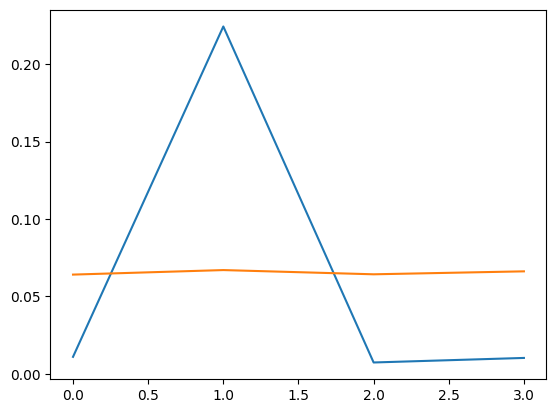

In [7]:
plt.plot(all_deltas[:, 0])
plt.plot(all_deltas[:, 1])

## Check 1: Consistency of `correctedDemand`

According to the signal flow diagram given in the MURAL board, `correctedDemand` = `Demand` + `correction`. The following function calculates the corrected demand from the available `Demand` and `correction` columns and compares it to the data provided in the `correctedDemand` column. Each deviation is considered as an anomaly.

In [39]:
def check_anomaly_corrected_demand(
        demand: pd.Series, 
        correction: pd.Series, 
        corrected_demand: pd.Series,
        threshold: float = 0.01,
    ) -> pd.Series:
    corrected_demand_calculated = demand + correction
    corrected_demand_deviation = np.abs(corrected_demand - corrected_demand_calculated)

    return corrected_demand_deviation > threshold

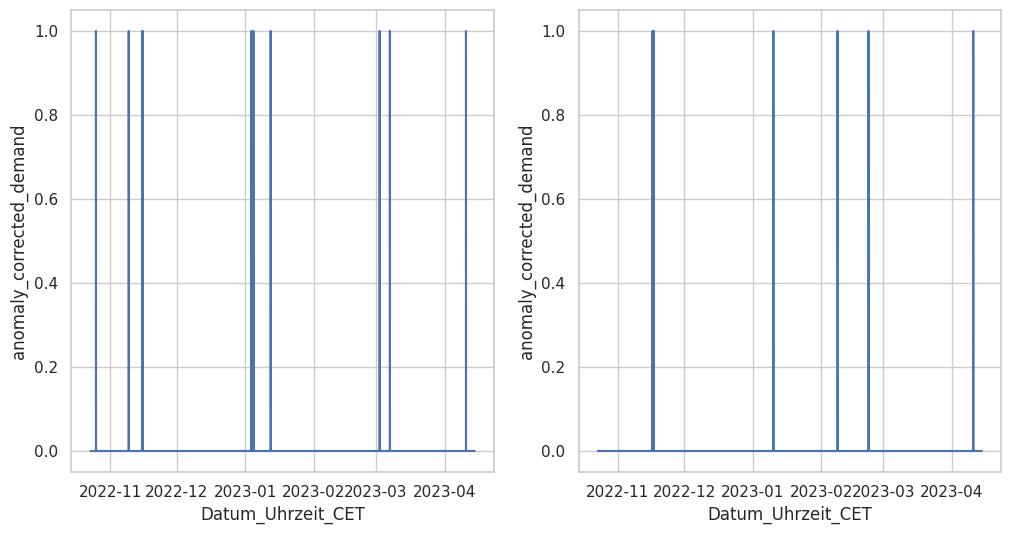

In [40]:
fig, axs = plt.subplots(1, 2)

for idx, control_area in enumerate([1, 2]):
    area_subset_train = dataset_train[dataset_train["controlArea"] == control_area]
    anomaly_corrected_demand = check_anomaly_corrected_demand(
        area_subset_train["Demand"],
        area_subset_train["correction"],
        area_subset_train["correctedDemand"],
    )

    with pd.option_context("mode.chained_assignment", None):
        area_subset_train["anomaly_corrected_demand"] = anomaly_corrected_demand

    sns.lineplot(x="Datum_Uhrzeit_CET", y="anomaly_corrected_demand", data=area_subset_train, ax=axs[idx])

plt.show()

## Legacy Plotting Stuff

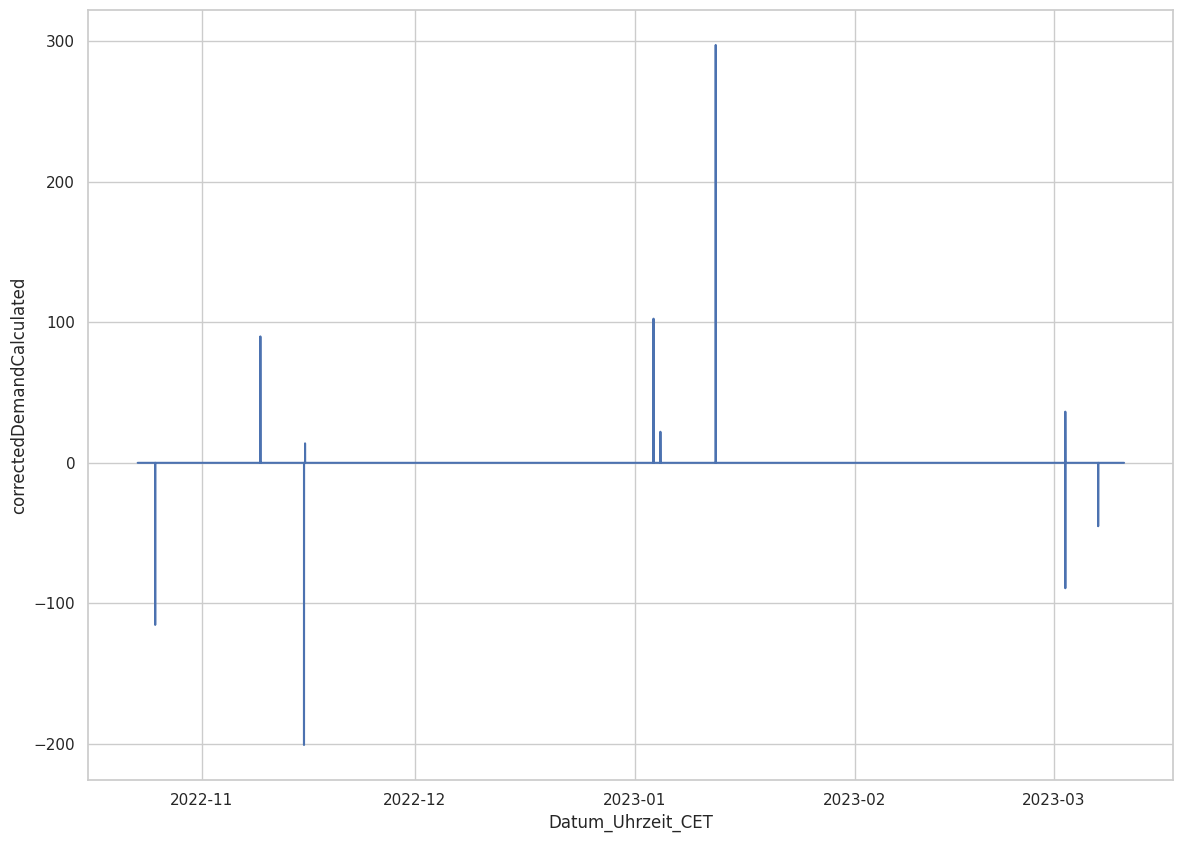

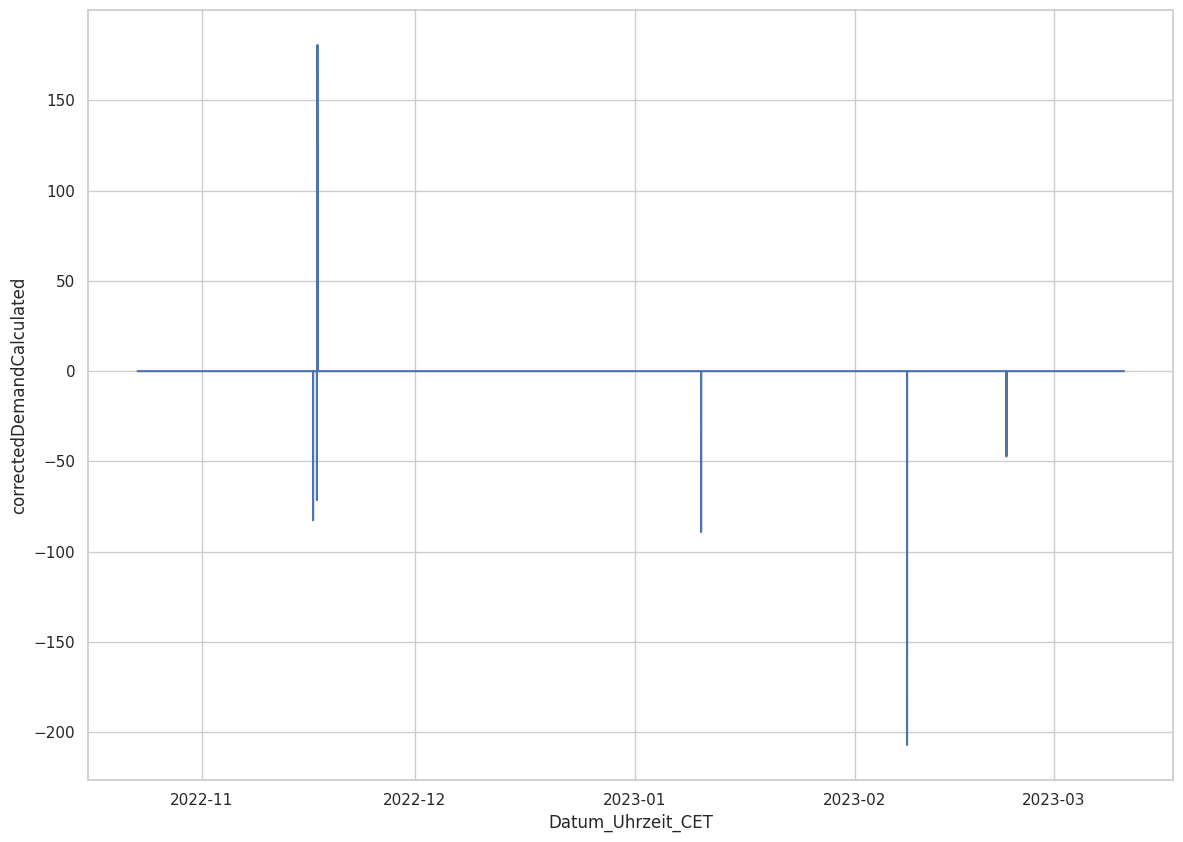

In [13]:
NUM_STEPS_THRESHOLD = 3000000

for control_area in [1, 2]:
    area_subset_train = dataset_train[dataset_train["controlArea"] == control_area][:NUM_STEPS_THRESHOLD]
    area_subset_train["aFRRdifference"] = (area_subset_train["aFRRactivation"] - area_subset_train["aFRRrequest"]).abs()
    area_subset_train["aFRRdifferenceShift"] = (area_subset_train["aFRRactivation"] - area_subset_train["aFRRrequest"].shift(periods=100)).abs()
    area_subset_train["correctedDemandCalculated"] = area_subset_train["correctedDemand"] - (area_subset_train["Demand"] + area_subset_train["correction"])

    fig, ax = plt.subplots()

    #sns.lineplot(x="Datum_Uhrzeit_CET", y="aFRRdifference", data=area_subset_train, ax=ax)
    #sns.lineplot(x="Datum_Uhrzeit_CET", y="aFRRdifferenceShift", data=area_subset_train, ax=ax)

    #sns.lineplot(x="Datum_Uhrzeit_CET", y="correctedDemand", data=area_subset_train, ax=ax)
    sns.lineplot(x="Datum_Uhrzeit_CET", y="correctedDemandCalculated", data=area_subset_train, ax=ax)

    #sns.lineplot(x="Datum_Uhrzeit_CET", y="Demand", data=area_subset_train, ax=ax, legend="full")
    #sns.lineplot(x="Datum_Uhrzeit_CET", y="correction", data=area_subset_train, ax=ax, legend="full")
    #sns.lineplot(x="Datum_Uhrzeit_CET", y="correctedDemand", data=area_subset_train, ax=ax)
    #sns.lineplot(x="Datum_Uhrzeit_CET", y="FRCE", data=area_subset_train, ax=ax)
    #sns.lineplot(x="Datum_Uhrzeit_CET", y="controlBandPos", data=area_subset_train, ax=ax)
    #sns.lineplot(x="Datum_Uhrzeit_CET", y="controlBandNeg", data=area_subset_train, ax=ax)
    #sns.lineplot(x="Datum_Uhrzeit_CET", y="LFCInput", data=area_subset_train, ax=ax)
    #sns.lineplot(x="Datum_Uhrzeit_CET", y="aFRRactivation", data=area_subset_train, ax=ax)
    #sns.lineplot(x="Datum_Uhrzeit_CET", y="aFRRrequest", data=area_subset_train, ax=ax)
    #sns.lineplot(x="Datum_Uhrzeit_CET", y="participationCMO", data=area_subset_train, ax=ax)
    #sns.lineplot(x="Datum_Uhrzeit_CET", y="participationIN", data=area_subset_train, ax=ax)
    #sns.lineplot(x="Datum_Uhrzeit_CET", y="correctionEcho", data=area_subset_train, ax=ax)
    #sns.lineplot(x="Datum_Uhrzeit_CET", y="BandLimitedCorrectedDemand", data=area_subset_train, ax=ax)

    #plt.legend(["Demand", "Correction", "CorrectedDemand"])

    plt.show()

In [5]:

NUM_STEPS_THRESHOLD = 30000

for control_area in [1,]:
    area_subset_train = dataset_train[dataset_train["controlArea"] == control_area][:NUM_STEPS_THRESHOLD]
    # Create a line plot for each column of interest
    fig = px.line(area_subset_train, x="Datum_Uhrzeit_CET", y="aFRRactivation", title="FFR")
    fig.add_scatter(x=area_subset_train["Datum_Uhrzeit_CET"], y=area_subset_train["aFRRrequest"], mode='lines', name='aFRR Request')
    fig.show()

    fig = px.line(area_subset_train, x="Datum_Uhrzeit_CET", y="correction", title="correction")
    fig.add_scatter(x=area_subset_train["Datum_Uhrzeit_CET"], y=area_subset_train["correctionEcho"], mode='lines', name='Correction Echo')
    fig.show()

    fig = px.line(area_subset_train, x="Datum_Uhrzeit_CET", y="FRCE", title="FRCE/LFCInput")
    fig.add_scatter(x=area_subset_train["Datum_Uhrzeit_CET"], y=area_subset_train["LFCInput"], mode='lines', name='LFC Input')
    fig.show()

    #fig.add_scatter(x=area_subset_train["Datum_Uhrzeit_CET"], y=area_subset_train["correctedDemand"], mode='lines', name='Corrected Demand')
    #fig.add_scatter(x=area_subset_train["Datum_Uhrzeit_CET"], y=area_subset_train["controlBandPos"], mode='lines', name='Control Band Pos')
    #fig.add_scatter(x=area_subset_train["Datum_Uhrzeit_CET"], y=area_subset_train["controlBandNeg"], mode='lines', name='Control Band Neg')
    #fig.add_scatter(x=area_subset_train["Datum_Uhrzeit_CET"], y=area_subset_train["participationCMO"], mode='lines', name='Participation CMO')
    #fig.add_scatter(x=area_subset_train["Datum_Uhrzeit_CET"], y=area_subset_train["participationIN"], mode='lines', name='Participation IN')
    #fig.add_scatter(x=area_subset_train["Datum_Uhrzeit_CET"], y=area_subset_train["BandLimitedCorrectedDemand"], mode='lines', name='Band Limited Corrected Demand')


In [ ]:
features = [
    "Demand", 
    "correction", 
    "correctedDemand", 
    "FRCE", 
    "controlBandPos", 
    "controlBandNeg", 
    "LFCInput", 
    "aFRRactivation", 
    "aFRRrequest", 
    "participationCMO", 
    "participationIN", 
    "correctionEcho", 
    "BandLimitedCorrectedDemand",
]

for control_area in [1, 2]:
    area_subset_train = dataset_train[dataset_train["controlArea"] == control_area]
    area_subset_train_scaled = StandardScaler().fit_transform(area_subset_train[features].values)

    mapper = PCA(n_components=2)
    embedding = mapper.fit_transform(area_subset_train_scaled)

    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1])
    plt.show()